# Convección en un gradiente de temperaturas lineal

Para realizar esta simulación tomé el modelo de `rayleigh_bernard` en dos dimensiones que venía en los ejemplos de dedalus, donde se resuelve para las variables de velocidad `(u, w)` y flotabilidad `b`, usando las siguientes ecuaciones:

$$\partial_x u + \partial_z w = 0,$$
$$\partial_t b - - P (\partial_{xx} b + \partial_{zz} b) - F * w = - u \partial_x b - w \partial_z b,$$
$$\partial_t u - R(\partial_{xx} u + \partial_{zz} u) + \partial_x P = - u \partial_x u - w \partial_z u,$$
$$\partial_t w - R(\partial_{xx} w + \partial_{zz} w) + \partial_z P = - u \partial_x w - w \partial_z w.$$

Ya que me interesa poner una estratificación como condición incial, expandí la flotabilidad como la diferencia de densidadades entre la parcela y una densidad promedio `ρ0`, donde la densidad de la parcela depende de la temperatura de la siguiente forma:

$$\rho = \rho_0 - \rho_0\alpha(T - T_0)^2.$$

La ecuación que rige la transferencia de calor es la ecuación calórica:

$$\partial_t T  - \kappa (\partial_{xx} T + \partial_{yy} T) = - u \partial_x T  - v \partial_y T$$.

Las ecuaciones de continuidad y de Navier-Stokes, se mantienen igual.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display
from matplotlib import animation

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

## Dominio del problema

In [4]:
Lx, Ly = (0.2, 0.35)
nx, ny = (256, 256)
#Prandtl = 1.
#Rayleigh = 5.8e7
ν = 1.8e-6
k = 2e-5
T0 = 4.0
T_b = 5.0 #Bottom temperature
g = 9.8
κ = 1.3e-7
ρ0 = 999.9720 # densidad a 4ºC
α = 8.1e-6
T_air = 21.
T_top = 4.
z_int = 0.18

Prandtl = ν/κ
print(Prandtl)
Rayleigh = (g*α*T0**2*(0.22)**3)/(ν*κ)
print(Rayleigh)

x_basis = de.Fourier('x', nx, interval=(0, Lx))
y_basis = de.Chebyshev('y', ny, interval=(0, Ly))
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

13.846153846153845
57794067.692307696


## Ecuaciones

In [5]:
problem = de.IVP(domain, variables=['p', 'u', 'v', 'ρ', 'T', 'uy', 'vy', 'Ty'])

In [6]:
problem.meta['p', 'T', 'u', 'v', 'ρ']['y']['dirichlet'] = True

In [7]:
#problem.parameters['P'] = (Rayleigh * Prandtl)**(-1/2)
#problem.parameters['R'] = (Rayleigh / Prandtl)**(-1/2)
#problem.parameters['F'] = F = 1
problem.parameters['ν'] = ν
problem.parameters['κ'] = κ
problem.parameters['T_air'] = T_air
problem.parameters['k'] = k 
problem.parameters['ρ0'] = ρ0
problem.parameters['T_0'] = T0 #4.0 ºC
problem.parameters['g'] = 9.8
problem.parameters['α'] = α
problem.parameters['T_b'] = T_b
problem.parameters['T_top'] = T_top

problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(u) - ν*(dx(dx(u)) + dy(uy)) + dx(p) = -(u*dx(u) + v*uy)")
problem.add_equation("dt(v) - ν*(dx(dx(v)) + dy(vy)) + dy(p) = -(u*dx(v) + v*vy) + g*(ρ - ρ0)/ρ0")
problem.add_equation("ρ = ρ0 - ρ0*α*(T - T_0)**2")
problem.add_equation("dt(T) - κ*(dx(dx(T)) + dy(Ty)) = - u*dx(T) - v*Ty - k*(T - T_air)")
problem.add_equation("Ty - dy(T) = 0")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")

problem.add_bc("left(T) = T_b")
problem.add_bc("right(T) = T_top")
problem.add_bc("left(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("right(p) = 0", condition="(nx == 0)")

## Condiciones de frontera

In [8]:
solver = problem.build_solver(de.timesteppers.RK222)

2017-06-28 10:29:06,845 pencil 0/1 INFO :: Building pencil matrix 1/128 (~1%) Elapsed: 0s, Remaining: 7s, Rate: 1.8e+01/s
2017-06-28 10:29:07,379 pencil 0/1 INFO :: Building pencil matrix 13/128 (~10%) Elapsed: 1s, Remaining: 5s, Rate: 2.2e+01/s
2017-06-28 10:29:08,022 pencil 0/1 INFO :: Building pencil matrix 26/128 (~20%) Elapsed: 1s, Remaining: 5s, Rate: 2.1e+01/s
2017-06-28 10:29:08,548 pencil 0/1 INFO :: Building pencil matrix 39/128 (~30%) Elapsed: 2s, Remaining: 4s, Rate: 2.2e+01/s
2017-06-28 10:29:09,096 pencil 0/1 INFO :: Building pencil matrix 52/128 (~41%) Elapsed: 2s, Remaining: 3s, Rate: 2.3e+01/s
2017-06-28 10:29:09,623 pencil 0/1 INFO :: Building pencil matrix 65/128 (~51%) Elapsed: 3s, Remaining: 3s, Rate: 2.3e+01/s
2017-06-28 10:29:10,168 pencil 0/1 INFO :: Building pencil matrix 78/128 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 2.3e+01/s
2017-06-28 10:29:10,714 pencil 0/1 INFO :: Building pencil matrix 91/128 (~71%) Elapsed: 4s, Remaining: 2s, Rate: 2.3e+01/s
2017-06-28

## Condiciones iniciales

In [9]:
x = domain.grid(0)
y = domain.grid(1)
T = solver.state['T']
Ty = solver.state['Ty']
ρ = solver.state['ρ']

#### Perfil de temepratura lineal

In [10]:
yb, yt = y_basis.interval

In [11]:
yt

0.35

In [12]:
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)

In [13]:
y.shape

(1, 256)

In [14]:
T['g'].shape

(256, 256)

In [53]:
T['g'] = 40.257128492422666*y - 300.5817711700071*y**2 + 1113.2658191481735*y**3

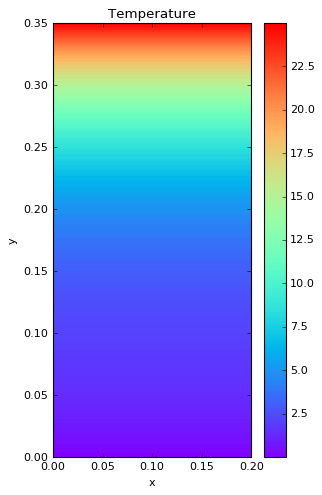

In [54]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, T['g'].T, cmap='rainbow');
plt.colorbar(pT)
plt.title('Temperature')
plt.xlabel('x')
plt.ylabel('y')

In [55]:
yb, yt = y_basis.interval

In [56]:
yt

0.35

In [77]:
dy = Ly/ny

In [84]:
ny_half = np.int(.18/dy)

In [72]:
pert =  np.random.rand(nx,ny) * (yt - y) * (y - 0.18) * y * (y - 0.26)

In [73]:
pert[0,:].shape

(256,)

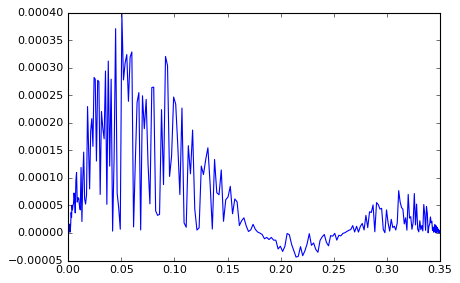

In [74]:
plt.plot(y[0], pert[0,:])

In [60]:
T['g'] = T['g'] + pert

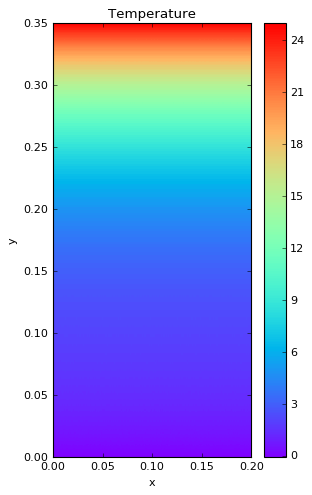

In [61]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, T['g'].T, cmap='rainbow');
plt.colorbar(pT)
plt.title('Temperature')
plt.xlabel('x')
plt.ylabel('y')

- $T0 = 4.0$. 
- $ρ0 = (999.9720 + 999.8395)/2$.
- $α = 8.1e-6$.

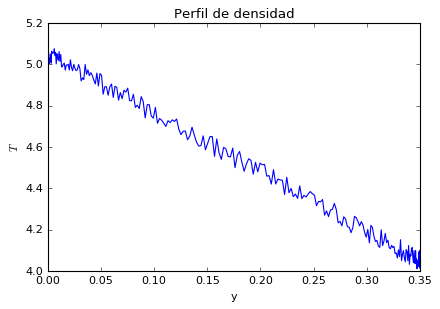

In [80]:
plt.plot(y[0], T['g'][5,:])
plt.title("Perfil de densidad")
plt.ylabel("$T$")
plt.xlabel('y')

In [81]:
ρ['g'] = ρ0 - ρ0*α*(T['g'] - T0)**2

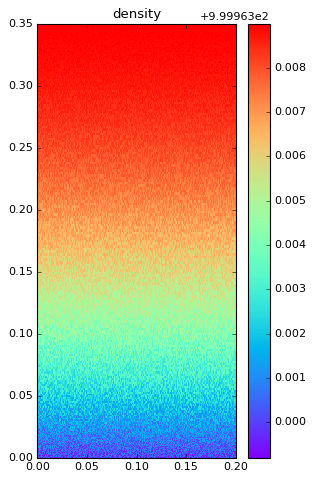

In [82]:
fig, axis = plt.subplots(figsize=(4,7))
pρ = axis.pcolormesh(xm, ym, ρ['g'].T, cmap='rainbow');
plt.colorbar(pρ)
plt.title('density')

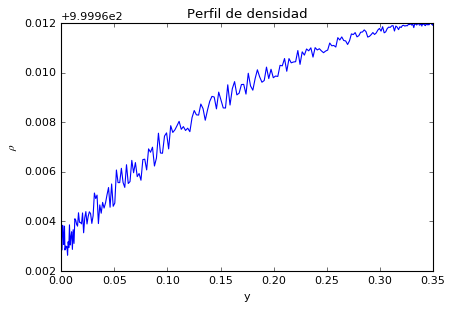

In [83]:
plt.plot(y[0], ρ['g'][5,:])
plt.title("Perfil de densidad")
plt.ylabel("$ρ$")
plt.xlabel('y')

In [84]:
# Initial timestep
dt = 0.1
# Integration parameters
solver.stop_sim_time = 60
solver.stop_wall_time = 30 * 90.
solver.stop_iteration = np.inf

# Analysis
snapshots = solver.evaluator.add_file_handler('strat_conv_analisys', sim_dt=0.25, max_writes=100)
snapshots.add_system(solver.state)

# CFL
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=1,
                     max_change=1.5, min_change=0.5, max_dt=0.125, threshold=0.05)
CFL.add_velocities(('u', 'v'))

#flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
#flow.add_property("sqrt(u*u + v*v) / R", name='Re')

In [91]:
flow_tools.CFL

2700.0

In [88]:
CFL.compute_dt()

0.1

In [26]:
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.ok:
        #print("hola")
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            # Update plot of scalar field
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
            #logger.info('Max Re = %f' %flow.max('Re'))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))

2017-06-15 09:14:54,509 __main__ 0/1 INFO :: Starting loop
2017-06-15 09:14:54,894 __main__ 0/1 INFO :: Iteration: 1, Time: 1.000000e-01, dt: 1.000000e-01
2017-06-15 09:14:57,797 __main__ 0/1 INFO :: Iteration: 11, Time: 1.350000e+00, dt: 1.250000e-01
2017-06-15 09:15:00,860 __main__ 0/1 INFO :: Iteration: 21, Time: 2.600000e+00, dt: 1.250000e-01
2017-06-15 09:15:03,524 __main__ 0/1 INFO :: Iteration: 31, Time: 3.850000e+00, dt: 1.250000e-01
2017-06-15 09:15:05,846 __main__ 0/1 INFO :: Iteration: 41, Time: 5.100000e+00, dt: 1.250000e-01
2017-06-15 09:15:08,094 __main__ 0/1 INFO :: Iteration: 51, Time: 6.350000e+00, dt: 1.250000e-01
2017-06-15 09:15:10,614 __main__ 0/1 INFO :: Iteration: 61, Time: 7.600000e+00, dt: 1.250000e-01
2017-06-15 09:15:12,822 __main__ 0/1 INFO :: Iteration: 71, Time: 8.850000e+00, dt: 1.250000e-01
2017-06-15 09:15:15,212 __main__ 0/1 INFO :: Iteration: 81, Time: 1.010000e+01, dt: 1.250000e-01
2017-06-15 09:15:17,307 __main__ 0/1 INFO :: Iteration: 91, Time: 1.1

# Análisis de datos

In [27]:
def extraer_datos(nombre_h5):

    with h5py.File(nombre_h5, flag ='r') as hdf:
        base_items = list(hdf.items())
        print(base_items, '\n')
        tasks = hdf.get('tasks')
        tasks_items = list(tasks.items())
        print(tasks_items)

        T = np.array(tasks.get('T'))
        print(T.shape)

        ρ = np.array(tasks.get('ρ'))
        print(ρ.shape)
        
    return T, ρ

In [28]:
def animar_dedalus(xm, ym, S, CMAP):
    fig, axis = plt.subplots(figsize=(4,7))
    p = axis.pcolormesh(xm, ym, S[0,:,:].T, cmap=CMAP)
    plt.colorbar(p)

    def init():
                print('update init')
                p.set_array(np.ravel(S[0,:-1,:-1].T))
                return p

    def update(frame):
        p.set_array(np.ravel(S[frame, :-1, :-1].T))
        return p

    anim = animation.FuncAnimation(fig, update, frames= [i for i in range(1,len(S))], init_func=init,  blit = False)
    plt.show()
    return anim

In [29]:
T_dat , ρ_dat = extraer_datos('strat_conv_analisys/strat_conv_analisys_s3/strat_conv_analisys_s3_p0.h5')

[('scales', <HDF5 group "/scales" (10 members)>), ('tasks', <HDF5 group "/tasks" (8 members)>)] 

[('p', <HDF5 dataset "p": shape (100, 128, 128), type "<f8">), ('u', <HDF5 dataset "u": shape (100, 128, 128), type "<f8">), ('v', <HDF5 dataset "v": shape (100, 128, 128), type "<f8">), ('T', <HDF5 dataset "T": shape (100, 128, 128), type "<f8">), ('uy', <HDF5 dataset "uy": shape (100, 128, 128), type "<f8">), ('ρ', <HDF5 dataset "ρ": shape (100, 128, 128), type "<f8">), ('vy', <HDF5 dataset "vy": shape (100, 128, 128), type "<f8">), ('Ty', <HDF5 dataset "Ty": shape (100, 128, 128), type "<f8">)]
(100, 128, 128)
(100, 128, 128)


In [30]:
ρ_dat.shape

(100, 128, 128)

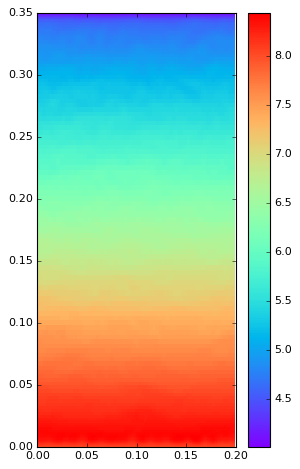

In [31]:
fig, axis = plt.subplots(figsize=(4,7))
p = axis.pcolormesh(xm, ym, T_dat[99].T, cmap='rainbow');
plt.colorbar(p)

update init


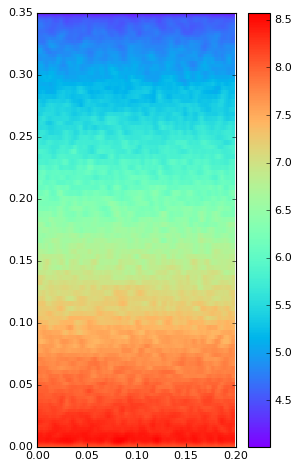

update init


In [46]:
anima = animar_dedalus(xm, ym, T_dat, 'rainbow')
mywriter = animation.FFMpegWriter()
anima.save('strat_conv_T.mp4',writer=mywriter, fps=30)